In [2]:
import torch
from pycocotools.coco import COCO
from random import shuffle
import os
import numpy as np
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

**Reference:** [tutorial](https://www.kaggle.com/code/armanasgharpoor1993/coco-dataset-tutorial-image-segmentation#Step-16:-Generating-Image-and-Mask-Datasets)

## Przeformatowanie i zredukowanie zbioru danych do 10 klas

In [2]:
# Load paths for the COCO dataset annotation files 
ANNOTATION_FILE_TRAIN = 'annotations/instances_train2017.json' # Change this to the yours path of the annotations file
ANNOTATION_FILE_VAL = 'annotations/instances_val2017.json' # Change this to the yours path of the annotations file

# Initialize COCO instances for training set and load relevant data
coco_train = COCO(ANNOTATION_FILE_TRAIN)
coco_val = COCO(ANNOTATION_FILE_VAL)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: 'annotations/instances_train2017.json'

### Ograniczenie zbioru danych do 10 klas zwierząt i podzielenie go na zbiór treningowy (8000)  oraz (2000) walidacyjny

In [62]:
# Define the object classes of interest
classes = ['cat', 'dog', 'horse', 'bird', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']


# --------------------------------- Training Set ---------------------------------

catIds_train = coco_train.getCatIds(catNms=classes)

imgIds_train = set()
for catId in catIds_train:
    imgIds_train.update(coco_train.getImgIds(catIds=[catId]))
imgDict_train = coco_train.loadImgs(imgIds_train)


# --------------------------------- Validation Set ---------------------------------

catIds_val = coco_val.getCatIds(catNms=classes)

imgIds_val = set()
for catId in catIds_val:
    imgIds_val.update(coco_val.getImgIds(catIds=[catId]))
imgDict_val = coco_val.loadImgs(imgIds_val)

# Print the number of training and validation images and categories
print(f"Number of images and classes in train seet: {len(imgIds_train)},{len(catIds_train)} ")
print(f"Number of images and classes in validation seet: {len(imgIds_val)},{len(catIds_val)} ")

# Convert the image IDs to a list
imgIds_train = list(imgIds_train)
imgIds_val = list(imgIds_val)

# Shuffle the training and validation image IDs
shuffle(imgIds_train)
shuffle(imgIds_val)

# Select a subset of validation image IDs
imgIds_val = imgIds_val[0:2000]
imgIds_train = imgIds_train[0:8000]

# Generate the list of file names for training and validation  images
train_images = ["{0:012d}.jpg".format(ids) for ids in imgIds_train]
val_images = ["{0:012d}.jpg".format(ids) for ids in imgIds_val]

# Print the number of training and validation images
print(f"Number of training nad validation images: {len(train_images)}, {len(val_images)}")

Number of images and classes in train seet: 23989,10 
Number of images and classes in validation seet: 1016,10 
Number of training nad validation images: 8000, 1016


### Ekstrakcja masek i obrazów do oddzielnego zbioru danych coco10



In [63]:
# Paths to the output annotations, images, and masks
output_train_image_dir = 'coco10/train2017_subset/images/'
output_train_mask_dir = 'coco10/train2017_subset/masks/'
output_val_image_dir = 'coco10/val2017_subset/images/'
output_val_mask_dir = 'coco10/val2017_subset/masks/'

# Create output directories for images and masks
os.makedirs(output_train_image_dir, exist_ok=True)
os.makedirs(output_train_mask_dir, exist_ok=True)
os.makedirs(output_val_image_dir, exist_ok=True)
os.makedirs(output_val_mask_dir, exist_ok=True)

# Initialize a count variable
count = 0

# Generate the masks and images for training images
for ID in imgIds_train:
    # Set the file path for the mask and image
    mask_file_path = os.path.join(output_train_mask_dir, "{0:012d}.jpg".format(ID))
    image_file_path = os.path.join(output_train_image_dir, "{0:012d}.jpg".format(ID))

    # Retrieve a random image ID from the training set
    sampleImgIds = coco_train.getImgIds(imgIds=[ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve the annotation IDs and annotations for the image
    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    # Generate the mask by combining the individual instance masks
    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_train.annToMask(anns[i])

    # Convert the mask to an image and save it
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(mask_file_path)

    # Load the corresponding image and save it
    image = Image.open(os.path.join('train2017', sampleImgDict['file_name']))  # Ensure this path matches your image location
    image.save(image_file_path)

    count += 1

# Reset the count variable
count = 0

# Generate the masks and images for validation images
for ID in imgIds_val:
    # Set the file path for the mask and image
    mask_file_path = os.path.join(output_val_mask_dir, "{0:012d}.jpg".format(ID))
    image_file_path = os.path.join(output_val_image_dir, "{0:012d}.jpg".format(ID))

    # Retrieve a random image ID from the validation set
    sampleImgIds = coco_val.getImgIds(imgIds=[ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # Retrieve the annotation IDs and annotations for the image
    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    # Generate the mask by combining the individual instance masks
    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    # Convert the mask to an image and save it
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(mask_file_path)

    # Load the corresponding image and save it
    image = Image.open(os.path.join('val2017', sampleImgDict['file_name']))  # Ensure this path matches your image location
    image.save(image_file_path)

    count += 1


### Utworzenie nowego pliku JSON zgodnego z COCO, zawierającego adnotacje i obrazy dla wybranych 10 klas zwierząt. 

In [1]:
# Function to create new annotation JSON for images in the given dataset (train or validation)
def create_new_coco_json(coco, img_ids, catIds, classes, output_json_path):
    new_coco = {
    "images": [],
    "annotations": [],
    "categories": []
    }

    # Define the categories you want to keep
    class_names = classes
    cat_ids = catIds  # For training, use the appropriate catIds from your filtered dataset

    # Create category list for new COCO annotations
    new_categories = [{"id": cid, "name": name, "supercategory": "animal"} for cid, name in zip(cat_ids, class_names)]
    new_coco["categories"] = new_categories


    annotation_id = 1
    for img_id in tqdm(img_ids):
        img_dict = coco.loadImgs([img_id])[0]
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=0)
        anns = coco.loadAnns(ann_ids)

        # Add the image information to the new JSON
        image_info = {
            "id": img_id,
            "file_name": img_dict["file_name"],
            "height": img_dict["height"],
            "width": img_dict["width"]
        }
        new_coco["images"].append(image_info)

        # Add annotations for this image
        for ann in anns:
            ann_info = {
                "id": annotation_id,
                "image_id": img_id,
                "category_id": ann["category_id"],
                "segmentation": ann["segmentation"],
                "area": ann["area"],
                "bbox": ann["bbox"],
                "iscrowd": ann["iscrowd"]
            }
            new_coco["annotations"].append(ann_info)
            annotation_id += 1

    # Save the new COCO JSON file
    with open(output_json_path, "w") as json_file:
        json.dump(new_coco, json_file)

# Create new COCO JSON for training set
create_new_coco_json(coco_train, imgIds_train, catIds_train, classes ,'coco10/train2017_subset/coco10_train_annotations.json')

# Create new COCO JSON for validation set
create_new_coco_json(coco_val, imgIds_val, catIds_val, classes, 'coco10/val2017_subset/coco10_val_annotations.json')

NameError: name 'cat_ids' is not defined

### Wizualizacja rozkładu kategorii w zbiorze danych COCO


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


/tmp/ipykernel_330065/2933190864.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts, y=category_names, palette=colors)


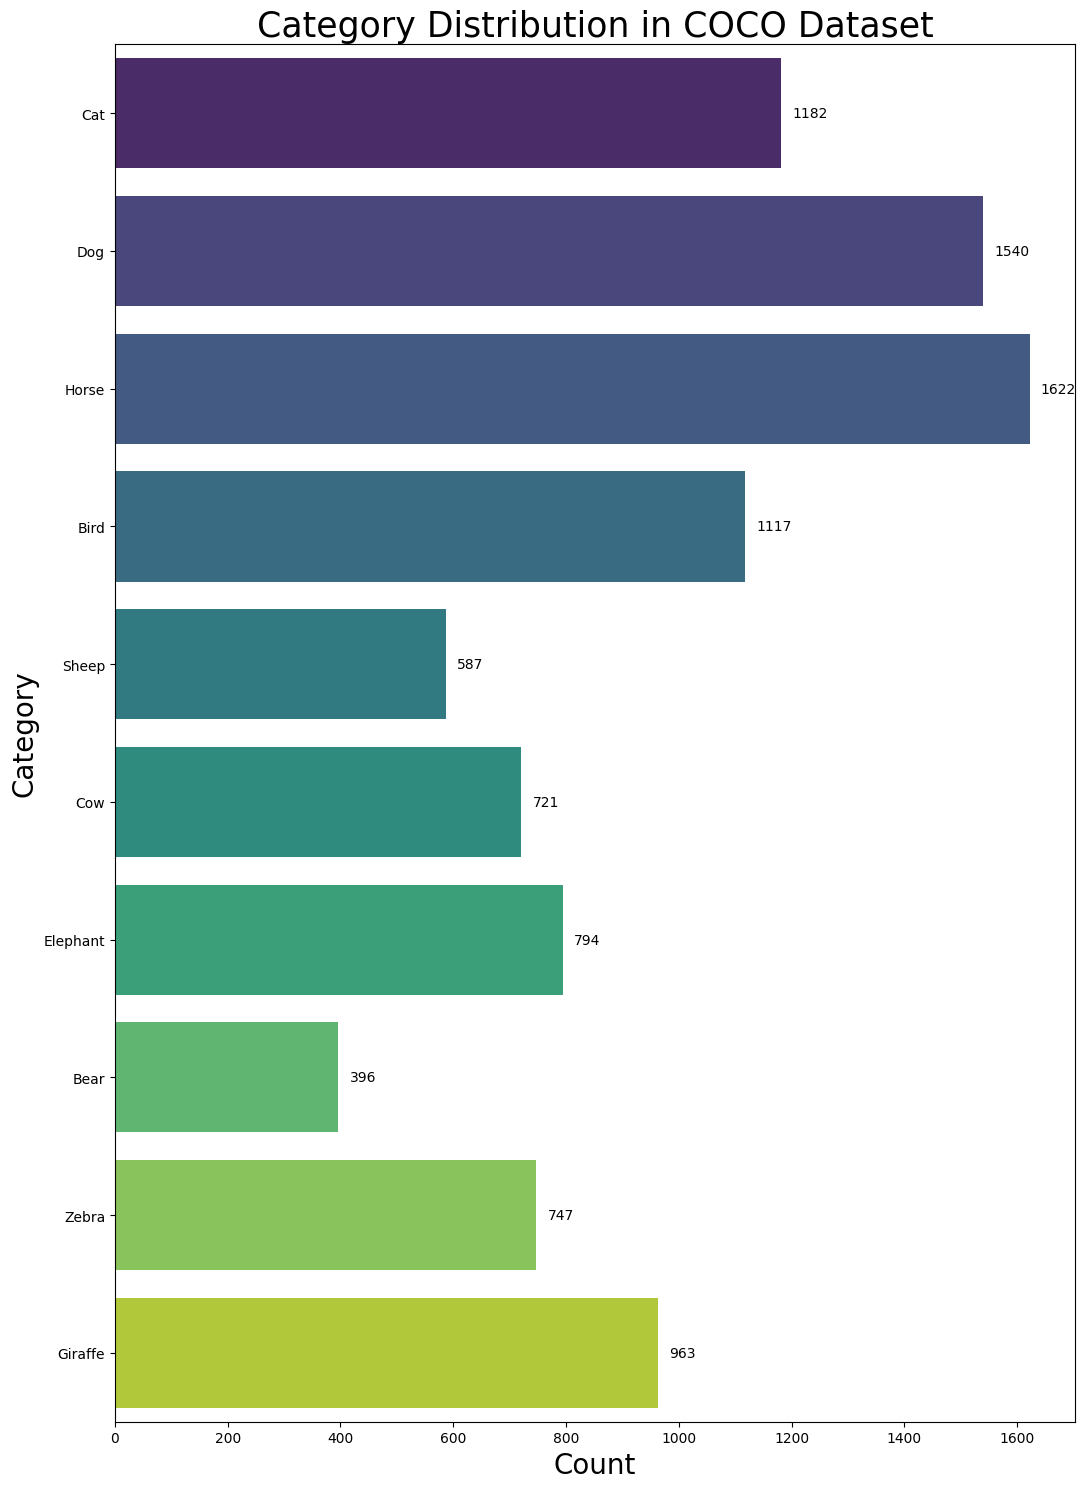

In [3]:
ANNOTATION_FILE_TRAIN = 'coco10/val2017_subset/coco10_val_annotations.json'

coco = COCO(ANNOTATION_FILE_TRAIN)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

# Get category names
category_names = [cat['name'].title() for cat in cats]

# Get category counts
category_counts = [coco.getImgIds(catIds=[cat['id']]) for cat in cats]
category_counts = [len(img_ids) for img_ids in category_counts]


# Create a color palette for the plot
colors = sns.color_palette('viridis', len(category_names))

# Create a horizontal bar plot to visualize the category counts
plt.figure(figsize=(11, 15))
sns.barplot(x=category_counts, y=category_names, palette=colors)

# Add value labels to the bars
for i, count in enumerate(category_counts):
    plt.text(count + 20, i, str(count), va='center')
plt.xlabel('Count',fontsize=20)
plt.ylabel('Category',fontsize=20)
plt.title('Category Distribution in COCO Dataset',fontsize=25)
plt.tight_layout()
plt.savefig('coco-cats.png',dpi=300)
plt.show()